In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
plt.style.use('ggplot')

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [4]:
train_data = pd.read_csv("/content/drive/MyDrive/Projects/EmotionsClassification/train.txt", header = None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")

In [5]:
train_data['length'] = [len(x) for x in train_data['Comment']]

In [6]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


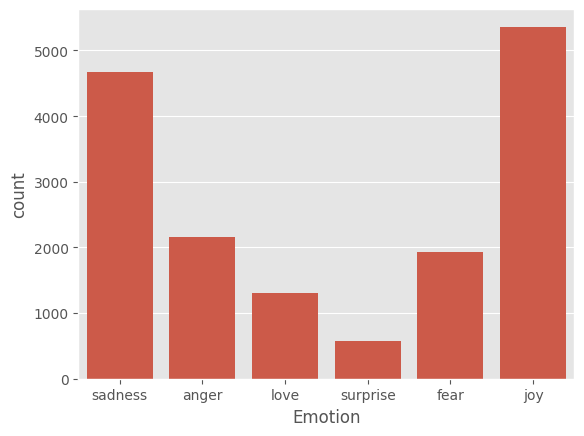

In [7]:
sns.countplot(x=train_data['Emotion'])
plt.show()

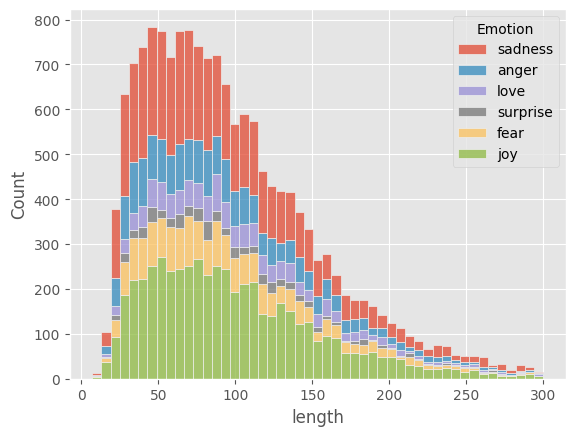

In [8]:
df2 = train_data.copy()
df2['length'] = [len(x) for x in train_data['Comment']]
length_value = df2['length'].values
sns.histplot(data=df2, x='length',hue='Emotion',multiple = 'stack')
plt.show()

In [9]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10,10))
    plt.title(df + ' Wordcloud', size = 15)
    plt.imshow(wordcloud)
    plt.axis("off")
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [13]:
df = train_data.copy()
df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [14]:
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_data(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ",text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment']  = df['Comment'].progress_apply(clean_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 16000/16000 [00:03<00:00, 5194.08it/s]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion'], test_size = 0.2, random_state=42)

In [17]:
tfidfvectorizer = TfidfVectorizer()
X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
X_test_tfidf = tfidfvectorizer.transform(X_test)

In [18]:
classifier={
    'MultinomialNB':MultinomialNB(),
    'LogisticRegression':LogisticRegression(),
    'Random Forest':RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}

for name,clf in classifier.items():
    print(f"\n============{name}============")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"======={accuracy_tfidf}============")
    print("Classification Report")
    print(classification_report(y_test, y_pred_tfidf))


============MultinomialNB============
=======0.655============
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


============LogisticRegression============


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=======0.829375============
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
           4       0.88      0.92      0.90       946
           5       0.77      0.45      0.57       113

    accuracy                           0.83      3200
   macro avg       0.82      0.72      0.76      3200
weighted avg       0.83      0.83      0.82      3200


============Random Forest============
=======0.8459375============
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       427
           1       0.81      0.83      0.82       397
           2       0.84      0.90      0.87      1021
           3       0.81      0.62      0.71       296
           4       0.91      0.88      0.90   

In [19]:
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
def predict_emotion(input_text):
    cleaned_text = clean_data(input_text)
    input_vectorizer = tfidfvectorizer.transform([cleaned_text])

    predicted_label = lg.predict(input_vectorizer)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label = np.max(lg.predict(input_vectorizer))

    return predicted_emotion, label

In [21]:
predict_emotion("She breakup with me")

('sadness', 4)

In [22]:
import pickle
pickle.dump(lg, open("logistic_regression.pkl","wb"))
pickle.dump(lb, open("label_encoder.pkl","wb"))
pickle.dump(tfidfvectorizer, open("tfidfvectorizer.pkl","wb"))

In [23]:
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ",text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    return pad

In [24]:
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

In [26]:
model = Sequential()
model.add(Embedding(input_dim = 11000, output_dim = 150, input_length = 300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))
model.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs = 10, batch_size = 64, verbose = 1, callbacks=[callback])

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.3045 - loss: 1.6299
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6279 - loss: 1.0092
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8423 - loss: 0.4628
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9086 - loss: 0.2751
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9379 - loss: 0.1879
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9546 - loss: 0.1364
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9551 - loss: 0.1272
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9659 - loss: 0.1048
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9677 - loss: 0.0923
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9720 - loss: 0.0821


In [27]:
model.save("model.h5")

In [29]:
from keras.models import load_model
model01 = load_model("model.h5")

In [30]:
def predictive_system_dl(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ",sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding="pre")
    return pad

In [31]:
sentence = predictive_system_dl("Iam feeling love with you")
result = lb.inverse_transform(np.argmax(model.predict(sentence), axis = 1))[0]
prob = np.max(model01.predict(sentence))
print(f"{result} with probability of {prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
love with probability of 0.9789531230926514


In [32]:
with open("lb1.pkl","wb") as f:
    pickle.dump(lb,f)
vocab_info = {"vocab_size": 11000, "max_len":300}
with open("vocab_info.pkl","wb") as f:
    pickle.dump(vocab_info, f)